<a href="https://colab.research.google.com/github/Redjo1258/DataRepo/blob/main/Tune_LandCover.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install some packages
!pip install rasterio
!pip install earthpy
!pip install keras
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 12.9 MB/s eta 0:00:00


In [ ]:
# Import packages
import rasterio
import pandas as pd
import numpy as np
import keras
from keras import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten, Input, GlobalMaxPooling1D
from keras.callbacks import EarlyStopping
from keras import Model
import rasterio as rio
import earthpy.plot as ep
from keras.utils import to_categorical, plot_model, model_to_dot
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import from_levels_and_colors

In [ ]:
# Mount GDRIVE
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Parameter
FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'EVI', 'NBR', 'NDMI', 'NDWI', 'NDBI', 'NDBaI', 'elevation']
LABEL = ['classvalue']
SPLIT = ['sample']
N_CLASSES = 7
CLASSES = [1, 2, 3, 4, 5, 6, 7]
PALETTE = ['#F08080', '#D2B48C', '#966D2A', '#84962A', '#CFDD44', '#44AFDD', '#02471C']
SAMPLE_PATH = '/content/drive/MyDrive/ADS4/Samples_LC_Cirebon_2023_3.csv'
IMAGE_PATH = '/content/drive/MyDrive/ADS4/Landsat_Cirebon_2023_3.tif'

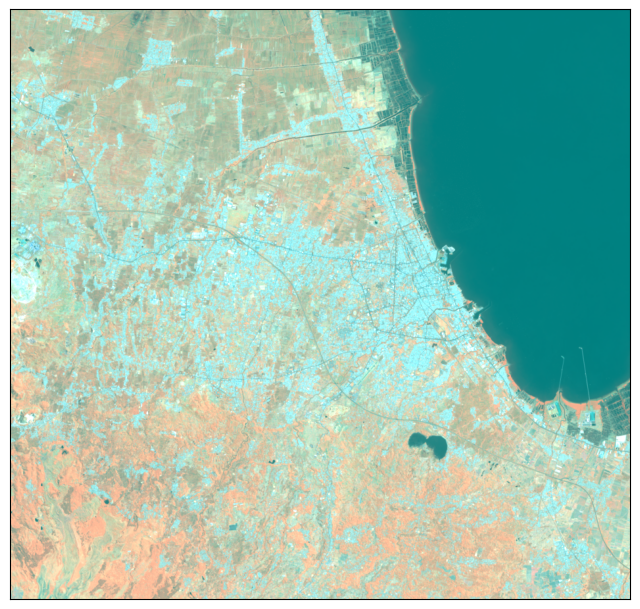

<Axes: >

In [ ]:
# Load image
image = rio.open(IMAGE_PATH)
bandNum = image.count
height = image.height
width = image.width
crs = image.crs
transform = image.transform
shape = (height, width)

image_vis = []
for x in [5, 6, 7]:
  image_vis.append(image.read(x))
image_vis = np.stack(image_vis)

plot_size = (8, 8)
ep.plot_rgb(
  image_vis,
  figsize=plot_size,
  stretch=True,
)

In [ ]:
# Read sample
samples = pd.read_csv(SAMPLE_PATH)
samples = samples.sample(frac = 1) # Shuffle data
samples

,B1,B2,B3,B4,B5,B6,B7,EVI,NBR,NDMI,NDWI,NDBI,NDBaI,elevation,classvalue,sample
10666,0.003225,0.018267,0.043842,0.006112,-0.001532,0.012520,0.012382,-0.021280,-1.282488,-1.278953,1.072442,1.278953,0.005522,0,6,test
8535,0.008106,0.028057,0.084652,0.042784,0.006456,0.012836,0.011571,-0.086270,-0.283733,-0.330698,0.858274,0.330698,0.051828,0,6,train
7154,0.009495,0.029378,0.059737,0.017305,-0.001780,0.008890,0.009440,-0.054113,-1.464752,-1.500703,1.061424,1.500703,-0.030005,0,6,train
9990,0.003995,0.016865,0.040680,0.004600,-0.001092,0.011585,0.011283,-0.015812,-1.214426,-1.208244,1.055194,1.208244,0.013228,0,6,test
10179,0.001960,0.014857,0.039580,0.005123,-0.000515,0.012300,0.011695,-0.015339,-1.092129,-1.087399,1.026366,1.087399,0.025214,0,6,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7219,0.011283,0.030065,0.059160,0.014143,-0.001450,0.007845,0.008615,-0.045437,-1.404745,-1.453479,1.050251,1.453479,-0.046780,0,6,train
3604,0.054347,0.059696,0.082012,0.084721,0.241127,0.193387,0.125105,0.300381,0.316800,0.109870,-0.492403,-0.109870,0.214393,6,3,train
11810,0.013647,0.019285,0.043265,0.029048,0.298520,0.134537,0.056795,0.507226,0.680312,0.378662,-0.746829,-0.378662,0.406321,632,7,train
304,0.073487,0.081352,0.104563,0.130825,0.232685,0.280810,0.229412,0.180925,0.007082,-0.093720,-0.379906,0.093720,0.100735,23,1,train


In [ ]:
# Split into train and test based on column
train = samples[samples['sample'] == 'train']
test = samples[samples['sample'] == 'test']

# Split between features and label
train_features = train[FEATURES]
train_label = train[LABEL]
test_features = test[FEATURES]
test_label = test[LABEL]

# Function to reshape array input
def reshape_input(array):
  shape = array.shape
  return array.reshape(shape[0], shape[1], 1)

# Convert samples dataframe (pandas) to numpy array
train_input = reshape_input(train_features.to_numpy())
test_input = reshape_input(test_features.to_numpy())

# Also make label data to categorical
train_output = to_categorical(train_label.to_numpy(), N_CLASSES + 1)
test_output = to_categorical(test_label.to_numpy(), N_CLASSES + 1)

# Show the data shape
print(f'Train features: {train_input.shape}\nTest features: {test_input.shape}\nTrain label: {train_output.shape}\nTest label: {test_output.shape}')

Train features: (9429, 14, 1)
Test features: (2501, 14, 1)
Train label: (9429, 8)
Test label: (2501, 8)


In [ ]:
# Make model for our data
# Input shape
train_shape = train_input.shape
input_shape = (train_shape[1], train_shape[2])

# Model parameter
neuron = 64
drop = 0.2
kernel = 2
pool = 2

# Make sequential model
model = Sequential([
  Input(input_shape),
  Conv1D(neuron * 1, kernel, activation='relu'),
  Conv1D(neuron * 1, kernel, activation='relu'),
  MaxPooling1D(pool),
  Dropout(drop),
  Conv1D(neuron * 2, kernel, activation='relu'),
  Conv1D(neuron * 2, kernel, activation='relu'),
  MaxPooling1D(pool),
  Dropout(drop),
  GlobalMaxPooling1D(),
  Dense(neuron * 2, activation='relu'),
  Dropout(drop),
  Dense(neuron * 1, activation='relu'),
  Dropout(drop),
  Dense(N_CLASSES + 1, activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 13, 64)              │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 12, 64)              │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 5, 128)              │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 4, 128)              │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 2, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 83,144 (324.78 KB)

 Trainable params: 83,144 (324.78 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model

# Compline the model
model.compile(
    optimizer='Adam',
    loss='CategoricalCrossentropy',
    metrics=['accuracy']
)

# Create callback to stop training if loss not decreasing
stop = EarlyStopping(
    monitor='loss',
    patience=5
)

# Fit the model
result = model.fit(
    x=train_input, y=train_output,
    validation_data=(test_input, test_output),
    batch_size=1024,
    callbacks=[stop],
    epochs=100,
)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.3060 - loss: 2.0776 - val_accuracy: 0.3471 - val_loss: 1.9439
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.5287 - loss: 1.4430 - val_accuracy: 0.3966 - val_loss: 1.4322
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - accuracy: 0.5902 - loss: 1.0072 - val_accuracy: 0.5742 - val_loss: 1.2064
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.7314 - loss: 0.8532 - val_accuracy: 0.8009 - val_loss: 0.9772
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.8006 - loss: 0.6725 - val_accuracy: 0.8061 - val_loss: 0.7240
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.8388 - loss: 0.5254 - val_accuracy: 0.8101 - val_loss: 0.5418
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.8542 - loss: 0.4305 - val_accuracy: 0.8401 - val_loss: 0.4066
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.8652 - loss: 0.3761 - val_accuracy

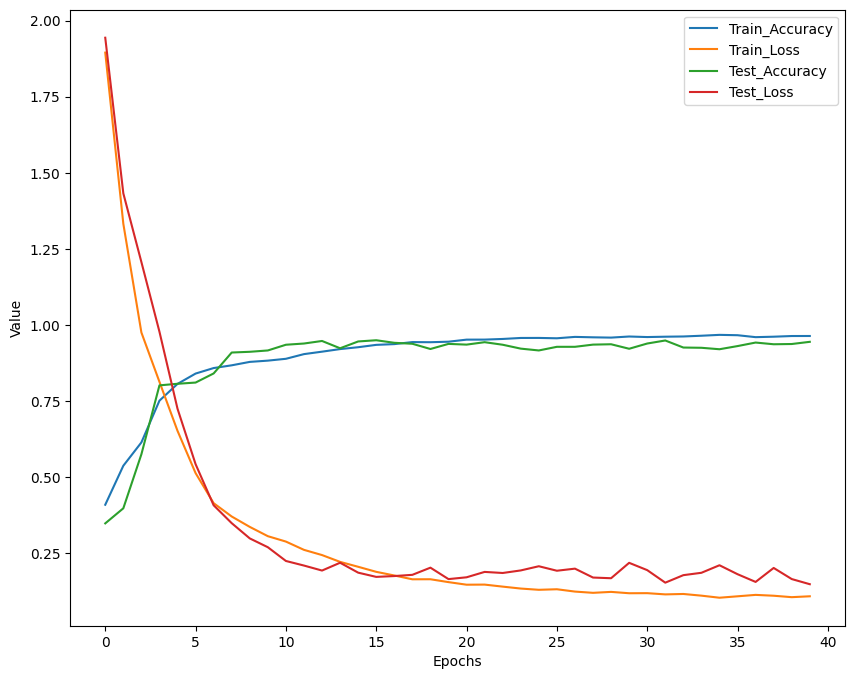

In [ ]:
# Show history
history = pd.DataFrame(result.history)

plt.figure(figsize = (10, 8))
plt.plot(range(len(history['accuracy'].values.tolist())), history['accuracy'].values.tolist(), label = 'Train_Accuracy')
plt.plot(range(len(history['loss'].values.tolist())), history['loss'].values.tolist(), label = 'Train_Loss')
plt.plot(range(len(history['val_accuracy'].values.tolist())), history['val_accuracy'].values.tolist(), label = 'Test_Accuracy')
plt.plot(range(len(history['val_loss'].values.tolist())), history['val_loss'].values.tolist(), label = 'Test_Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           1       0.96      0.99      0.98       578
           2       0.97      0.90      0.93       243
           3       0.91      0.91      0.91       610
           4       0.98      1.00      0.99        52
           5       0.34      0.36      0.35        73
           6       1.00      0.99      0.99       945
           7       0.00      0.00      0.00         0

    accuracy                           0.94      2501
   macro avg       0.74      0.74      0.74      2501
weighted avg       0.95      0.94      0.94      2501



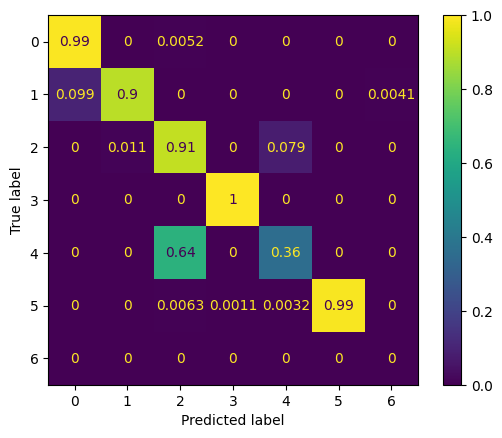

In [ ]:
# Predict test data
prediction = np.argmax(model.predict(test_input), 1).flatten()
label = np.argmax(test_output, 1).flatten()

# Confusion matrix
cm = confusion_matrix(label, prediction, normalize='true')
cm = ConfusionMatrixDisplay(cm)
cm.plot()

# Classification report
print(classification_report(label, prediction))

11/11 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step


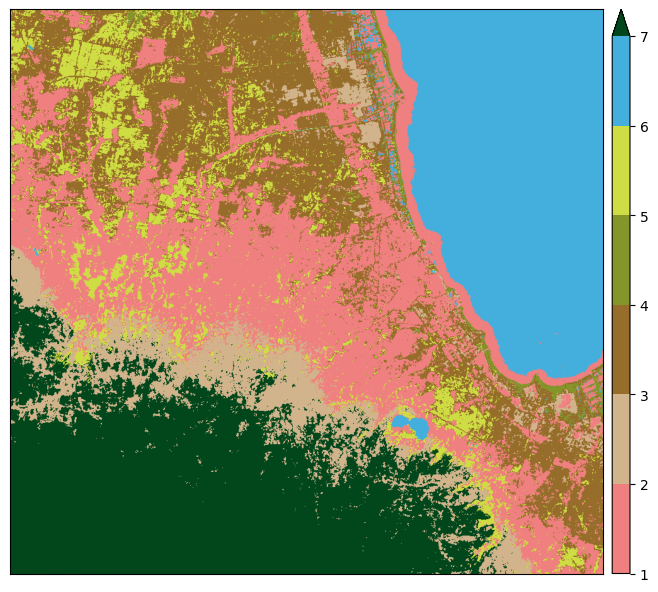

<Axes: >

In [ ]:
# Predict image using the model
image_input = []
for x in range(14):
  image_input.append(image.read(x + 1))
image_input = reshape_input(np.stack(image_input).reshape(14, -1).T)

# Predict
prediction = model.predict(image_input, batch_size=4096*20)
prediction = np.argmax(prediction, 1)
prediction = prediction.reshape(shape[0], shape[1])

# Visualize
cmap, norm = from_levels_and_colors(CLASSES, PALETTE, extend='max')
ep.plot_bands(prediction, cmap=cmap, norm=norm, figsize=plot_size)

In [ ]:
# Save file to drive
save_location = '/content/drive/MyDrive/ADS4/'
name = 'LC_Cirebon_2023_fix.tif'
location = save_location + name

new_dataset = rasterio.open(
      location,
      mode='w', driver='GTiff',
      height = prediction.shape[0], width = prediction.shape[1],
      count=1, dtype=str(prediction.dtype),
      crs=crs,
      transform=transform
)
new_dataset.write(prediction, 1);
new_dataset.close()